### Imports

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
import math
import pickle
import datetime

from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Reshape, Lambda, ZeroPadding2D, GaussianNoise, AlphaDropout, Input, Concatenate
from keras.layers.core import Flatten, Dropout
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical, normalize

from sklearn.model_selection import train_test_split
import tensorflow as tf

from scipy import ndimage
from skimage.morphology import reconstruction
from skimage.restoration import denoise_wavelet, denoise_tv_chambolle, denoise_nl_means


random_seed = 54321
np.random.seed(random_seed)
cwd = os.getcwd()
#for windows
model_path = cwd + '\\models\\'

Using TensorFlow backend.


Manually create tensorflow session to avoid potential OEM errors on laptop's GPU.

In [2]:
tf.set_random_seed(random_seed)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.set_session(session)
K.set_image_dim_ordering('tf')

In [3]:
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


### Load Data

In [4]:
data = pd.read_json("Data/train/train.json", orient='records')
data.head()
train_df = data

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 5 columns):
band_1        1604 non-null object
band_2        1604 non-null object
id            1604 non-null object
inc_angle     1604 non-null object
is_iceberg    1604 non-null int64
dtypes: int64(1), object(4)
memory usage: 62.7+ KB


### Missing values

In [6]:
train_df['inc_angle_f'] = pd.to_numeric(train_df['inc_angle'], errors='coerce')
print("missing values in inc_angle: ", train_df['inc_angle_f'].isnull().sum())
#train_df['inc_angle_f'].replace(np.nan,train_df['inc_angle_f'].mean(), inplace=True)
train_df['inc_angle_f'].replace(np.nan,0, inplace=True)
train_df.tail()

missing values in inc_angle:  133


,band_1,band_2,id,inc_angle,is_iceberg,inc_angle_f
1599,"[-30.999878, -29.976866, -28.233906, -29.50732...","[-27.847719, -28.233864, -24.712077999999998, ...",04e11240,na,0,0.0
1600,"[-25.31155, -26.511555, -28.694487, -27.180115...","[-29.563713, -28.290375, -26.839405, -28.29046...",c7d6f6f8,na,0,0.0
1601,"[-18.141895, -18.141844, -19.01737, -19.701599...","[-25.305355, -29.387701, -28.963863, -26.16023...",bba1a0f1,na,0,0.0
1602,"[-22.455633, -25.794661, -26.954567, -22.83354...","[-26.070356, -22.093737, -21.577662, -24.53376...",7f66bb44,na,0,0.0
1603,"[-19.909191, -20.678406, -20.208834, -18.42441...","[-24.44487, -24.956001, -27.722103, -26.078417...",9d8f326c,na,0,0.0


### Transform for NN

In [7]:
def get_bands(train_df):
    max_col = np.array(train_df.apply(lambda x: max((max(train_df.loc[x.name,'band_1']),max(train_df.loc[x.name,'band_2']))),axis=1)) - 10
    max_col2 = max_col.reshape(-1,1) * np.ones(75*75).reshape(1,75*75)
    max_col2 = max_col2.reshape(-1,75,75)

    band_1 = np.array(train_df['band_1'].tolist()).reshape(-1,75,75) - max_col2
    band_2 = np.array(train_df['band_2'].tolist()).reshape(-1,75,75) - max_col2
    band_1_t = 10**(band_1/10)
    band_2_t = 10**(band_2/10)
    band_1_t = np.where(band_1_t > 0.01, band_1_t, 0)
    band_2_t = np.where(band_2_t > 0.01, band_2_t, 0)
    band_3 = band_1_t - band_2_t
    X = np.stack((band_1,band_2,band_1_t,band_2_t),axis=3)
    
    return band_1, band_2, band_1_t, band_2_t, band_3, X

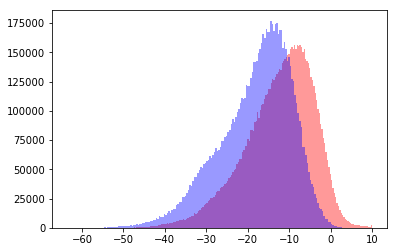

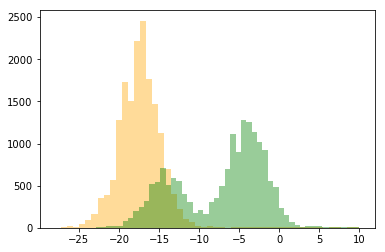

In [8]:
band_1, band_2, band_1_t, band_2_t, band_3, X = get_bands(train_df)
plt.hist(band_1.flatten(), bins=200, color="red", alpha=0.4)
plt.hist(band_2.flatten(), bins=200, color="blue", alpha=0.4)
plt.show()

plt.hist(band_1[train_df[train_df['is_iceberg']==0].index[:3]].flatten(), bins=50, color="orange", alpha=0.4)
plt.hist(band_1[train_df[train_df['is_iceberg']==1].index[:3]].flatten(), bins=50, color="green", alpha=0.4)
plt.show()

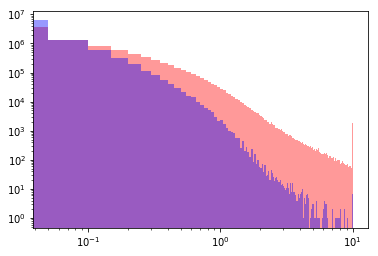

In [9]:
plt.hist(band_1_t.flatten(),bins=200, color="red", alpha=0.4)
plt.hist(band_2_t.flatten(),bins=200, color="blue", alpha=0.4)
plt.yscale('log')
plt.xscale('log')
plt.show()

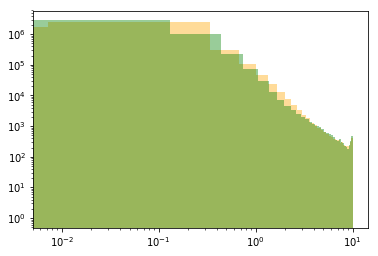

In [10]:
plt.hist(band_3[train_df[train_df['is_iceberg']==0].index].flatten(), bins=50, color="orange", alpha=0.4)
plt.hist(band_3[train_df[train_df['is_iceberg']==1].index].flatten(), bins=50, color="green", alpha=0.4)
plt.yscale('log')
plt.xscale('log')
plt.show()

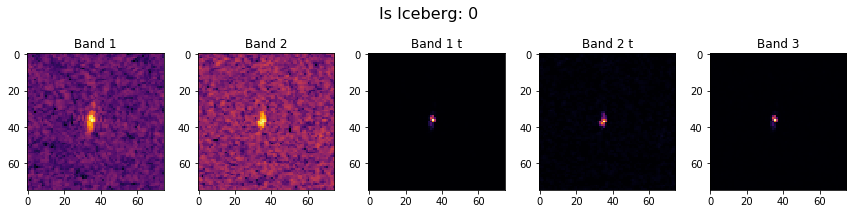

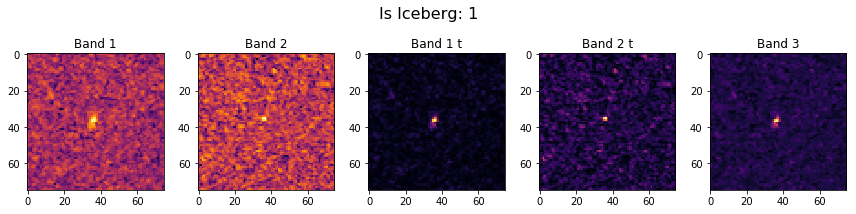

In [11]:
def plot_bands(index, cmap="gray"):
    fig = plt.figure(figsize=(12,6))
    fig.suptitle("Is Iceberg: %x" % (train_df.loc[index,'is_iceberg']), fontsize=16)
    ax1 = fig.add_subplot(251)
    ax1.set_title("Band 1")
    ax1.imshow(band_1[index], cmap=cmap)
    ax2 = fig.add_subplot(252)
    ax2.set_title("Band 2")
    ax2.imshow(band_2[index], cmap=cmap)
    ax3 = fig.add_subplot(253)
    ax3.set_title("Band 1 t")
    ax3.imshow(band_1_t[index], cmap=cmap)
    ax3 = fig.add_subplot(254)
    ax3.set_title("Band 2 t")
    ax3.imshow(band_2_t[index], cmap=cmap)
    ax3 = fig.add_subplot(255)
    ax3.set_title("Band 3")
    ax3.imshow(band_3[index], cmap=cmap)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_bands(0,cmap="inferno")
plot_bands(2,cmap="inferno")


In [12]:
y = train_df.loc[:,'is_iceberg']
y_angle = train_df.loc[:,['is_iceberg','inc_angle_f']]
y_angle['index'] = y_angle.index

In [13]:
y_angle.head()

,is_iceberg,inc_angle_f,index
0,0,43.9239,0
1,0,38.1562,1
2,1,45.2859,2
3,0,43.8306,3
4,0,35.6256,4


### Split into train test and validation sets

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y_angle, test_size=0.3, random_state=random_seed)
print(X_train.shape)
print(X_val.shape)

(1122, 75, 75, 4)
(482, 75, 75, 4)


### Data augmentation

In [15]:
X_train_sample = X_train[:]
y_train_sample = y_train[:]
print(X_train_sample.shape)

datagen = ImageDataGenerator(
    samplewise_center=False,
    samplewise_std_normalization=False,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

datagen_val = ImageDataGenerator(
    samplewise_center=False,
    samplewise_std_normalization=False,
    rotation_range=0,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest')

#custom generator for fit_generator
from collections import Generator
class Datagen_angle(Generator):
    def __init__(self, imagegen=ImageDataGenerator):
        self.imagegen = imagegen
        
    def flow(self, x, y, batch_size=8, shuffle=True):
        self.generator = self.imagegen.flow(x, y, batch_size=batch_size, shuffle=shuffle)
        return self
    
    def send(self, ignored):
        temp_data = next(self.generator)
        temp_band_3 = temp_data[0][:,:,:,2] - temp_data[0][:,:,:,3] #band_1_t - band_2_t
        temp_stacked1 = np.stack((temp_data[0][:,:,:,0],temp_data[0][:,:,:,1]),axis=3)
        temp_stacked2 = np.stack((temp_data[0][:,:,:,2],temp_data[0][:,:,:,3],temp_band_3),axis=3)
        nn_denoised_temp = temp_data[0] #pass 4 bands for nn denoising input
        return [temp_stacked1, temp_stacked2, 
                nn_denoised_temp,
                temp_data[1][:,1]], temp_data[1][:,0]
    
    def throw(self, type=None, value=None, traceback=None):
        raise StopIteration
    

datagen.fit(X_train_sample)
datagen_val.fit(X_val)

datagen_angle = Datagen_angle(imagegen=datagen)
datagen_angle_val = Datagen_angle(imagegen=datagen_val)


(1122, 75, 75, 4)


### Denoising

In [16]:
def denoising(img):
    img_list = []
    for i in range(4):
        image = normalize(img[:,:,i])
        img_list.append(ndimage.median_filter(image, 3))
    return np.stack(img_list,axis=2)

In [17]:
def apply_over_axis(func, data, mask=None, axis=0, *args, **kwargs):
    f_list = []
    for i in range(data.shape[axis]):
        if mask is None:
            f_list.append(func(data[i], *args, **kwargs))
        else:
            f_list.append(func(data[i], mask=mask[i], *args, **kwargs))
    return np.stack(f_list,axis=0)

In [18]:
#X_denoised = apply_over_axis(denoising, X)

In [19]:
#index=8
#original_index = y_train_sample.iloc[index].name
#cmap="inferno"
#fig = plt.figure(figsize=(12,6))
#fig.suptitle("Denoising: is iceberg: %x" % (y_train_sample.iloc[index,0]), fontsize=16)
#ax1 = fig.add_subplot(251)
#ax1.set_title("Before")
#ax1.imshow(X_train_sample[index][:,:,0], cmap=cmap)
#ax2 = fig.add_subplot(252)
#ax2.set_title("Denoised")
#ax2.imshow(X_denoised[original_index][:,:,0], cmap=cmap)
#ax1 = fig.add_subplot(253)
#ax1.set_title("Before - band 2")
#ax1.imshow(X_train_sample[index][:,:,1], cmap=cmap)
#ax2 = fig.add_subplot(254)
#ax2.set_title("Denoised - band 2")
#ax2.imshow(X_denoised[original_index][:,:,1], cmap=cmap)
#plt.show()

### NN denoising

In [20]:
#custom generator for denoising
from collections import Generator
class Datagen_denoising(Generator):
    def __init__(self, imagegen=ImageDataGenerator):
        self.imagegen = imagegen
        
    def flow(self, x, y, batch_size=8, shuffle=True):
        self.generator = self.imagegen.flow(x, y, batch_size=batch_size, shuffle=shuffle)
        return self
    
    def send(self, ignored):
        temp_data = next(self.generator)
        temp_stacked1 = np.stack((temp_data[0][:,:,:,0],temp_data[0][:,:,:,1]),axis=3)
        temp_stacked = np.stack((temp_data[0][:,:,:,0],temp_data[0][:,:,:,1],temp_data[0][:,:,:,2],
                                temp_data[0][:,:,:,3]),axis=3)
        return temp_stacked, temp_stacked
    
    def throw(self, type=None, value=None, traceback=None):
        raise StopIteration
        
datagen_denoising = Datagen_denoising(imagegen=datagen)
datagen_denoising_val = Datagen_denoising(imagegen=datagen_val)

In [21]:
m_input = Input(shape=(75,75,4), name='m_input')

#conv layers for main_input
x1 = BatchNormalization()(m_input)
x1 = ZeroPadding2D()(x1)
x1 = Conv2D(8, (3,3), activation='relu')(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)
x1 = ZeroPadding2D()(x1)
x1 = Conv2D(8, (3,3), activation='relu')(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)
x1 = ZeroPadding2D()(x1)
m_output = Conv2D(4, (3,3), activation='linear', name='m_output')(x1)
model_denoise = Model(inputs=[m_input,], outputs=[m_output], name='Model_nn_denoising')

model_denoise.compile(optimizer=Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0),
loss='mean_squared_error',
metrics=['mae'])

In [22]:
#model_denoise.summary()

In [23]:
#model training
start_time = time.monotonic()

H = model_denoise.fit_generator(datagen_denoising.flow(X, y_angle, batch_size=8),
                    steps_per_epoch=len(X)/8,
                    validation_data=datagen_denoising_val.flow(X, y_angle, batch_size=8, shuffle=False), 
                    validation_steps=len(X)/8,
                    #validation_data=[X_val,y_val],
                    epochs=10)

model_time = time.monotonic() - start_time
print("Model training time: " + '{:d}'.format(int(model_time // 60)) + " minutes " 
      + '{:.1f}'.format(model_time % 60) + " seconds")

Epoch 1/10
201/200 [==============================] - 7s - loss: 18.7332 - mean_absolute_error: 2.3995 - val_loss: 15.0345 - val_mean_absolute_error: 2.2504
Epoch 2/10
201/200 [==============================] - 4s - loss: 11.6767 - mean_absolute_error: 1.9071 - val_loss: 18.2488 - val_mean_absolute_error: 2.3652
Epoch 3/10
201/200 [==============================] - 4s - loss: 12.4343 - mean_absolute_error: 1.9341 - val_loss: 15.6824 - val_mean_absolute_error: 2.1681
Epoch 4/10
201/200 [==============================] - 4s - loss: 11.9273 - mean_absolute_error: 1.9402 - val_loss: 4.0987 - val_mean_absolute_error: 1.2210
Epoch 5/10
201/200 [==============================] - 4s - loss: 9.4170 - mean_absolute_error: 1.7453 - val_loss: 9.4401 - val_mean_absolute_error: 1.7518
Epoch 6/10
201/200 [==============================] - 4s - loss: 9.3435 - mean_absolute_error: 1.7267 - val_loss: 5.4971 - val_mean_absolute_error: 1.3591
Epoch 7/10
201/200 [==============================] - 4s - loss

In [24]:
X_nn_denoised = model_denoise.predict(X, verbose=1)

1568/1604 [============================>.] - ETA: 0s

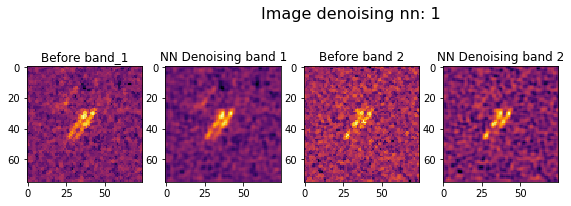

In [25]:
index=8
original_index = y_train_sample.iloc[index].name
cmap="inferno"
fig = plt.figure(figsize=(12,6))
fig.suptitle("Image denoising nn: %x" % (train_df.loc[original_index,'is_iceberg']), fontsize=16)
ax1 = fig.add_subplot(251)
ax1.set_title("Before band_1")
ax1.imshow(X_train_sample[index][:,:,0], cmap=cmap)
ax2 = fig.add_subplot(252)
ax2.set_title("NN Denoising band 1")
ax2.imshow(X_nn_denoised[original_index][:,:,0], cmap=cmap)
ax3 = fig.add_subplot(253)
ax3.set_title("Before band 2")
ax3.imshow(X_train_sample[index][:,:,1], cmap=cmap)
ax4 = fig.add_subplot(254)
ax4.set_title("NN Denoising band 2")
ax4.imshow(X_nn_denoised[original_index][:,:,1], cmap=cmap)
plt.show()

### Filtering regional maxima

In [26]:
#def img_filtering(img,mask,h=0.75):
#    img_list = []
#    for i in range(img.shape[2]):
#        image = img[:,:,i]
#        mask1 = mask[:,:,i]
#        h = (mask1.max() - mask1.min()) * h
#        seed = mask1 - h
#        dilated = reconstruction(seed, mask1, method='dilation')
#        hdome = image * dilated
#        img_list.append(hdome)
#    return np.stack(img_list,axis=2)
#
#def img_dilated(mask,h=0.2):
#    img_list = []
#    for i in range(mask.shape[2]):
#        mask1 = mask[:,:,i]
#        h = (mask1.max() - mask1.min()) * h
#        seed = mask1 - h
#        dilated = reconstruction(seed, mask1, method='dilation')
#        img_list.append(dilated)
#    return np.stack(img_list,axis=2)    

In [27]:
#X_filtered = apply_over_axis(img_filtering, X, mask=X_denoised)
#X_dilated = apply_over_axis(img_dilated, X_denoised )

In [28]:
#base_images = X_train_sample
#index=8
#original_index = y_train_sample.iloc[index].name
#cmap="inferno"
#fig = plt.figure(figsize=(14,6))
#fig.suptitle("Image filtering: %x" % (train_df.loc[original_index,'is_iceberg']), fontsize=16)
#ax1 = fig.add_subplot(251)
#ax1.set_title("Before")
#ax1.imshow(base_images[index][:,:,0], cmap=cmap)
#ax2 = fig.add_subplot(252)
#ax2.set_title("Filtered")
#ax2.imshow(X_filtered[original_index][:,:,0], cmap=cmap)
#ax1 = fig.add_subplot(253)
#ax1.set_title("Before - band 2")
#ax1.imshow(base_images[index][:,:,0], cmap=cmap)
#ax2 = fig.add_subplot(254)
#ax2.set_title("Filtered - band 2")
#ax2.imshow(X_filtered[original_index][:,:,0], cmap=cmap)
#ax4 = fig.add_subplot(255)
#ax4.set_title("Dilated - band 1")
#ax4.imshow(X_dilated[original_index][:,:,0], cmap=cmap)
#plt.show()

### Keras model

In [29]:
model_code="CNN_2017_12_21_v21"
model_comment="2 CNN inputs 3,3 conv filters - 3rd input nn denoising, na=0"

In [30]:
%%writefile current_model.py

def InputBlock(x, dropout=0.2, prefix=''):
    #conv layers for input
    x = BatchNormalization()(x)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x) 
    return(x)

main_input = Input(shape=(75,75,2), name='main_input')
aux_input = Input(shape=(75,75,3), name='aux_input')
aux_input_nn = Input(shape=(75,75,4), name='aux_input_nn')

x1 = InputBlock(main_input, prefix='m_input')
x2 = InputBlock(aux_input, prefix='a_input')
x3 = model_denoise(aux_input_nn)
x3 = InputBlock(x3,dropout=0.2, prefix='a_input_nn')

x = Concatenate(axis=3)([x1,x2,x3])
#x = BatchNormalization()(x)
#x = Dropout(0.2)(x)

#conv-block
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

#conv-block
x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
    
#flatten
x = Flatten()(x)
angle_input = Input(shape=[1], name='angle_input')
#x1 = BatchNormalization()(angle_input)
merged = Concatenate()([x, angle_input])

#dense-block
x = Dense(513, activation='relu')(merged)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

#dense-block
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

main_output = Dense(1, activation='sigmoid', name='main_output')(x)
model_f = Model(inputs=[main_input,aux_input, 
                        aux_input_nn, 
                        angle_input], 
                        outputs=[main_output])

model_f.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0),
loss='binary_crossentropy',
metrics=['accuracy'])

Overwriting current_model.py


In [31]:
%run -i current_model.py

In [32]:
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.66
    patience = 7.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/patience))
    if math.fmod(epoch, patience) == 0:
        print("Setting learning rate: ",lrate)
    return lrate

def step_decay2(epoch):
    initial_lrate = 0.000001
    drop = 0.66
    patience = 5.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/patience))
    if math.fmod(epoch, patience) == 0:
        print("Setting learning rate: ",lrate)
    return lrate

# learning rate schedule
class LScheduler:
    def __init__(self, initial_lrate=0.001):
        self.initial_lrate=initial_lrate

    def step_decay(epoch,logs):
        initial_lrate = self.initial_lrate
        drop = 0.66
        patience = 5.0
        lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/patience))
        if math.fmod(epoch, patience) == 0:
            print("Setting learning rate: ",lrate)
        return lrate

def get_callbacks(filepath, patience=10, step_decay=step_decay):
    #es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    #reduceLr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
    #                          patience=5, min_lr=0.000001, verbose=1)
    lrScheduler = LearningRateScheduler(step_decay)
    return [msave, lrScheduler]

In [33]:
model_f.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
aux_input_nn (InputLayer)        (None, 75, 75, 4)     0                                            
____________________________________________________________________________________________________
main_input (InputLayer)          (None, 75, 75, 2)     0                                            
____________________________________________________________________________________________________
aux_input (InputLayer)           (None, 75, 75, 3)     0                                            
____________________________________________________________________________________________________
Model_nn_denoising (Model)       (None, 75, 75, 4)     1252        aux_input_nn[0][0]               
___________________________________________________________________________________________

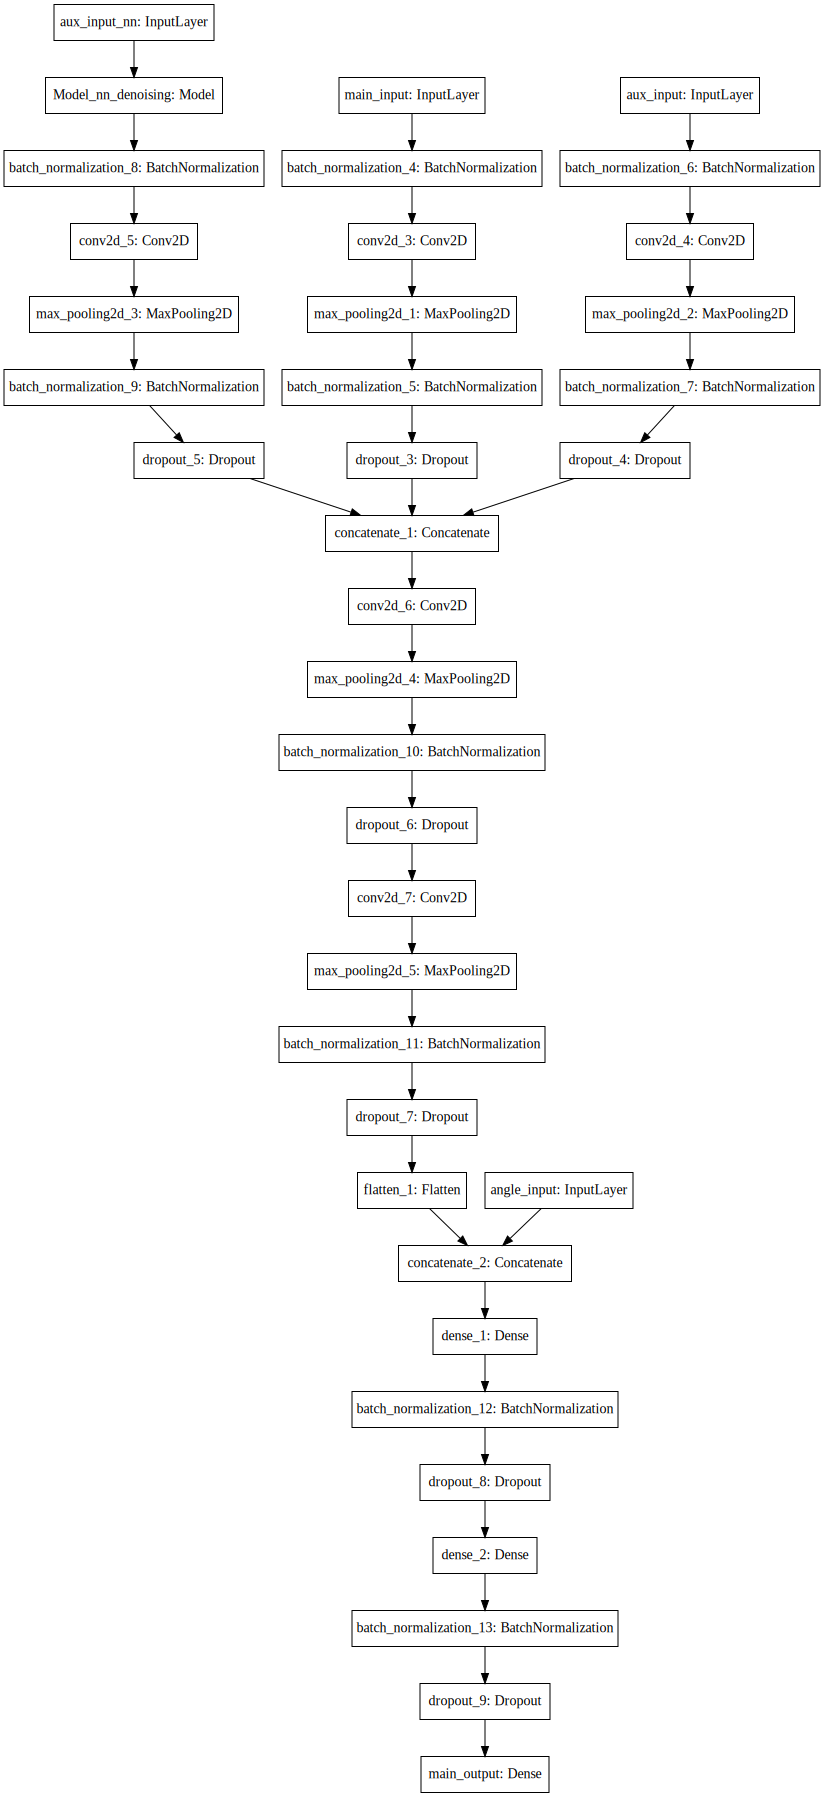

In [34]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
#import os
#os.environ["PATH"] += os.pathsep + 'd:/Anaconda3/Library/bin/graphviz/'
SVG(model_to_dot(model_f).create(prog='dot', format='svg'))

### Model Training

In [35]:
#name init
model_timestamp = str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S"))
model_best_weights_path = model_path + "weights." + model_code + "_" + model_timestamp + ".hdf5"
callbacks = get_callbacks(filepath=model_best_weights_path, patience=10, step_decay=step_decay)

In [36]:
#model training
start_time = time.monotonic()

H = model_f.fit_generator(datagen_angle.flow(X_train_sample, y_train_sample, batch_size=24),
                    steps_per_epoch=len(X_train_sample)/24,
                    validation_data=datagen_angle_val.flow(X_val, y_val, batch_size=24, shuffle=False), 
                    validation_steps=len(X_val)/12,
                    #validation_data=[X_val,y_val],
                    epochs=56, callbacks=callbacks)

model_time = time.monotonic() - start_time
print("Model training time: " + '{:d}'.format(int(model_time // 60)) + " minutes " 
      + '{:.1f}'.format(model_time % 60) + " seconds")

Setting learning rate:  0.001
Epoch 1/56
47/46 [==============================] - 22s - loss: 0.7528 - acc: 0.6339 - val_loss: 1.1941 - val_acc: 0.6081
Epoch 2/56
47/46 [==============================] - 19s - loss: 0.5561 - acc: 0.7213 - val_loss: 0.5349 - val_acc: 0.7543
Epoch 3/56
47/46 [==============================] - 19s - loss: 0.4643 - acc: 0.7778 - val_loss: 1.0021 - val_acc: 0.5000
Epoch 4/56
47/46 [==============================] - 19s - loss: 0.4565 - acc: 0.8014 - val_loss: 0.4396 - val_acc: 0.8223
Epoch 5/56
47/46 [==============================] - 19s - loss: 0.4317 - acc: 0.8038 - val_loss: 0.4832 - val_acc: 0.7415
Epoch 6/56
47/46 [==============================] - 19s - loss: 0.4143 - acc: 0.8150 - val_loss: 0.6217 - val_acc: 0.6521
Epoch 7/56
47/46 [==============================] - 19s - loss: 0.3818 - acc: 0.8395 - val_loss: 0.4559 - val_acc: 0.7649
Setting learning rate:  0.00066
Epoch 8/56
47/46 [==============================] - 19s - loss: 0.3857 - acc: 0.8283

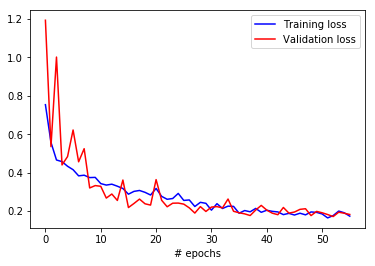

In [37]:
plt.plot(H.history['loss'], color="b", label='Training loss')
plt.plot(H.history['val_loss'], color="r", label='Validation loss')
plt.legend()
plt.xlabel('# epochs')
plt.show()

In [38]:
#addtional training epochs
callbacks = get_callbacks(filepath=model_best_weights_path, patience=10, step_decay=step_decay2)
start_time = time.monotonic()

H2 = model_f.fit_generator(datagen_angle.flow(X_train_sample, y_train_sample, batch_size=24),
                    steps_per_epoch=len(X_train_sample)/24,
                    validation_data=datagen_angle_val.flow(X_val, y_val, batch_size=32, shuffle=False), 
                    validation_steps=len(X_val)/12,
                    #validation_data=[X_val,y_val],
                    epochs=14, callbacks=callbacks)

model_time = time.monotonic() - start_time
print("Model training time: " + '{:d}'.format(int(model_time // 60)) + " minutes " 
      + '{:.1f}'.format(model_time % 60) + " seconds")

Setting learning rate:  1e-06
Epoch 1/14
47/46 [==============================] - 20s - loss: 0.1815 - acc: 0.9267 - val_loss: 0.1825 - val_acc: 0.9345
Epoch 2/14
47/46 [==============================] - 20s - loss: 0.1528 - acc: 0.9450 - val_loss: 0.1729 - val_acc: 0.9361
Epoch 3/14
47/46 [==============================] - 20s - loss: 0.1424 - acc: 0.9450 - val_loss: 0.1784 - val_acc: 0.9337
Epoch 4/14
47/46 [==============================] - 19s - loss: 0.1543 - acc: 0.9397 - val_loss: 0.1881 - val_acc: 0.9321
Epoch 5/14
47/46 [==============================] - 20s - loss: 0.1825 - acc: 0.9314 - val_loss: 0.1899 - val_acc: 0.9329
Setting learning rate:  6.6e-07
Epoch 6/14
47/46 [==============================] - 20s - loss: 0.1693 - acc: 0.9374 - val_loss: 0.1813 - val_acc: 0.9378
Epoch 7/14
47/46 [==============================] - 20s - loss: 0.1867 - acc: 0.9300 - val_loss: 0.1732 - val_acc: 0.9377
Epoch 8/14
47/46 [==============================] - 20s - loss: 0.1468 - acc: 0.9379

In [39]:
for key in H.history:
    H.history[key].extend(H2.history[key])

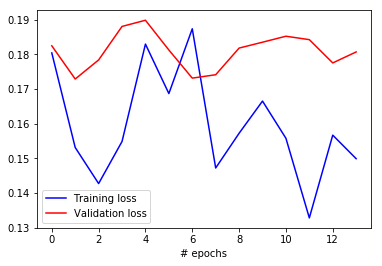

In [40]:
plt.plot(H2.history['loss'], color="b", label='Training loss')
plt.plot(H2.history['val_loss'], color="r", label='Validation loss')
plt.legend()
plt.xlabel('# epochs')
plt.show()

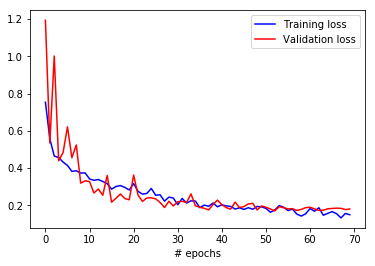

In [41]:
plt.plot(H.history['loss'], color="b", label='Training loss')
plt.plot(H.history['val_loss'], color="r", label='Validation loss')
plt.legend()
plt.xlabel('# epochs')
plt.show()

In [42]:
model_object_path = model_path + "model." + model_code + "_" + model_timestamp + '.hdf5'
model_f.save(model_object_path)
#model_f = load_model(model_object_path)

### Saving model history

In [43]:
argmin = np.array(H.history["val_loss"]).argmin()
argmax_acc = np.array(H.history["val_acc"]).argmax()
with open('current_model.py','r') as model_python_code_file:
    models_history = pd.DataFrame({"timestamp":[model_timestamp], 
                                    "val_loss [min]":[H.history['val_loss'][argmin]],
                                    "epoch [val_loss [min]]":argmin,
                                    "training_loss [val_loss [min]]":[H.history['loss'][argmin]],
                                    "val_acc [val_loss [min]]":[H.history['val_acc'][argmin]],
                                    "training_acc [val_loss [min]]":[H.history['acc'][argmin]],
                                    
                                    "val_acc [max]":[H.history['val_acc'][argmax_acc]],
                                    "epoch [val_acc [max]]":argmax_acc,
                                    "training_loss [val_acc [max]]":[H.history['loss'][argmax_acc]],
                                    "val_loss [val_acc [max]]":[H.history['val_loss'][argmax_acc]],
                                    "training_acc [val_acc [max]]":[H.history['acc'][argmax_acc]],
                                    
                                    "model_path":[model_object_path],
                                    "model_weights_path":[model_best_weights_path],
                                    "model_python_code":[model_python_code_file.read().replace('\r\n','\n')],
                                    "model_comment":[model_comment]
                                })
                               
models_history = models_history[["timestamp", 
                                 "epoch [val_loss [min]]", "val_loss [min]", "training_loss [val_loss [min]]",
                                 "val_acc [val_loss [min]]", "training_acc [val_loss [min]]",
                                 "epoch [val_acc [max]]", "val_acc [max]", "training_loss [val_acc [max]]",
                                 "val_loss [val_acc [max]]", "training_acc [val_acc [max]]",
                                 "model_path","model_weights_path","model_python_code","model_comment"]]
models_history.head()

,timestamp,epoch [val_loss [min]],val_loss [min],training_loss [val_loss [min]],val_acc [val_loss [min]],training_acc [val_loss [min]],epoch [val_acc [max]],val_acc [max],training_loss [val_acc [max]],val_loss [val_acc [max]],training_acc [val_acc [max]],model_path,model_weights_path,model_python_code,model_comment
0,2017_12_21_16_19_08,52,0.170289,0.175443,0.941489,0.938503,52,0.941489,0.175443,0.170289,0.938503,L:\Data Science\GIT\Statoil-C-CORE-Iceberg-Cla...,L:\Data Science\GIT\Statoil-C-CORE-Iceberg-Cla...,"\ndef InputBlock(x, dropout=0.2, prefix=''):\n...","2 CNN inputs 3,3 conv filters - 3rd input nn d..."


In [44]:
print("Min validation loss epoch:")
print("epoch: %d" %(argmin),
      "; val loss [min] %.4f: " % (models_history["val_loss [min]"][0]), 
      "; training loss: %.4f" % (models_history["training_loss [val_loss [min]]"][0]),
      "; val acc: %.4f" % (models_history["val_acc [val_loss [min]]"][0]),
      "; training acc: %.4f " % (models_history["training_acc [val_loss [min]]"][0])
     )
print("Max validation accuracy epoch:")
print("epoch: %d" %(argmax_acc),
      "; val loss %.4f: " % (models_history["val_loss [val_acc [max]]"][0]), 
      "; training loss: %.4f" % (models_history["training_loss [val_acc [max]]"][0]),
      "; val acc [max]: %.4f" % (models_history["val_acc [max]"][0]),
      "; training acc: %.4f " % (models_history["training_acc [val_acc [max]]"][0]),
     )
print("model comment:", model_comment)


Min validation loss epoch:
epoch: 52 ; val loss [min] 0.1703:  ; training loss: 0.1754 ; val acc: 0.9415 ; training acc: 0.9385 
Max validation accuracy epoch:
epoch: 52 ; val loss 0.1703:  ; training loss: 0.1754 ; val acc [max]: 0.9415 ; training acc: 0.9385 
model comment: 2 CNN inputs 3,3 conv filters - 3rd input nn denoising, na=0


In [45]:
with open('models_history.csv', 'a') as f:
    models_history.to_csv(f, header=False,index=False)
    #models_history.to_csv(f, index=False)

In [46]:
df = pd.read_csv('models_history.csv')
df.tail()

,timestamp,epoch [val_loss [min]],val_loss [min],training_loss [val_loss [min]],val_acc [val_loss [min]],training_acc [val_loss [min]],epoch [val_acc [max]],val_acc [max],training_loss [val_acc [max]],val_loss [val_acc [max]],training_acc [val_acc [max]],model_path,model_weights_path,model_python_code,model_comment
19,2017_12_20_23_03_06,52,0.296401,0.152571,0.879668,0.943850,59,0.887967,0.162104,0.300197,0.933155,/iceberg\models\model.CNN_2017_12_19_v15_2017_...,/iceberg\models\weights.CNN_2017_12_19_v15_201...,"\ndef InceptionBlock(x, n_kernels=32, prefix='...","VOLTA 2 CNN inputs 3,3 conv filters - inceptio..."
20,2017_12_20_23_39_40,120,0.210953,0.157278,0.923237,0.936720,120,0.923237,0.157278,0.210953,0.936720,/iceberg/models/model.CNN_2017_12_19_v15_2017_...,/iceberg/models/weights.CNN_2017_12_19_v15_201...,"\ndef InceptionBlock(x, n_kernels=64, prefix='...","VOLTA 2 CNN inputs 3,3 conv filters - inceptio..."
21,2017_12_21_15_35_25,48,0.190576,0.183202,0.929787,0.933155,45,0.930851,0.214926,0.195366,0.909091,L:\Data Science\GIT\Statoil-C-CORE-Iceberg-Cla...,L:\Data Science\GIT\Statoil-C-CORE-Iceberg-Cla...,"\ndef InputBlock(x, dropout=0.2, prefix=''):\n...","2 CNN inputs 3,3 conv filters - base model, no..."
22,2017_12_21_15_54_42,48,0.164204,0.191250,0.935106,0.919786,41,0.940426,0.203126,0.171025,0.920677,L:\Data Science\GIT\Statoil-C-CORE-Iceberg-Cla...,L:\Data Science\GIT\Statoil-C-CORE-Iceberg-Cla...,"\ndef InputBlock(x, dropout=0.2, prefix=''):\n...","2 CNN inputs 3,3 conv filters - base model, no..."
23,2017_12_21_16_19_08,52,0.170289,0.175443,0.941489,0.938503,52,0.941489,0.175443,0.170289,0.938503,L:\Data Science\GIT\Statoil-C-CORE-Iceberg-Cla...,L:\Data Science\GIT\Statoil-C-CORE-Iceberg-Cla...,"\ndef InputBlock(x, dropout=0.2, prefix=''):\n...","2 CNN inputs 3,3 conv filters - 3rd input nn d..."


### Predictions

In [47]:
model_f.load_weights(model_best_weights_path)

In [48]:
model_f.evaluate(X_val,y_val, verbose=1, batch_size=64)

ValueError: The model expects 4 input arrays, but only received one array. Found: array with shape (482, 75, 75, 4)

In [ ]:
test_df = pd.read_json("Data/test/test.json")

In [ ]:
test_df.head()

In [ ]:
t_band_1, t_band_2, t_band_1_t, t_band_2_t, t_band_3, X_test = get_bands(test_df)

In [ ]:
predictions = model.predict(X_test,verbose=1, batch_size=64)

In [ ]:
submission = pd.DataFrame({'id': test_df['id'], 'is_iceberg': predictions.reshape(-1)})
submission.head()

In [ ]:
submission.to_csv("submission.v7.csv", index=False)